The resources and coding styles used in this notebook is inspired by RITVIMATH under his time series analysis videos

In [2]:
pip install arch

                                              0.0/922.8 kB ? eta -:--:--
     ------------------------------------- 922.8/922.8 kB 28.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Needed libraries 
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

# In practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

For my stock preference, I would be using MSFT

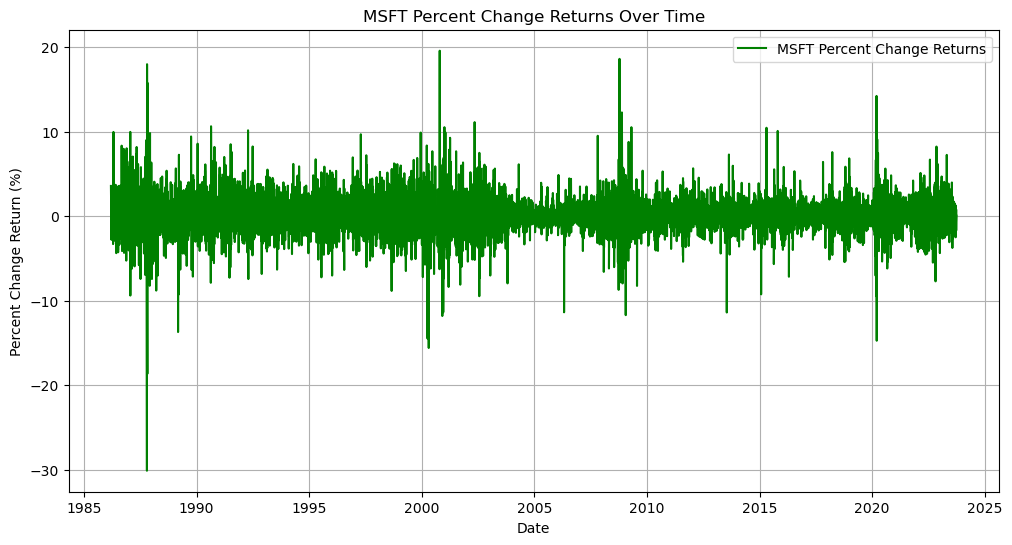

In [5]:
# Define the ticker symbol for Microsoft (MSFT)
ticker_symbol = "MSFT"

# Fetch historical data for Microsoft using yfinance
msft = yf.Ticker(ticker_symbol)
msft_data = msft.history(period="max")  

msft_data['Percent_Change_Return'] = msft_data['Close'].pct_change() * 100

# Remove the first row (NaN) since there's no return for the first day
msft_data = msft_data.dropna()

# Plot the daily percent change returns
plt.figure(figsize=(12, 6))
plt.plot(msft_data.index, msft_data['Percent_Change_Return'], label=f'{ticker_symbol} Percent Change Returns', color='green')
plt.title(f'{ticker_symbol} Percent Change Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Percent Change Return (%)')
plt.legend()
plt.grid(True)
plt.show()


Now I am going to determine what order of my GARCH Model I should use

C:\Users\jonat\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


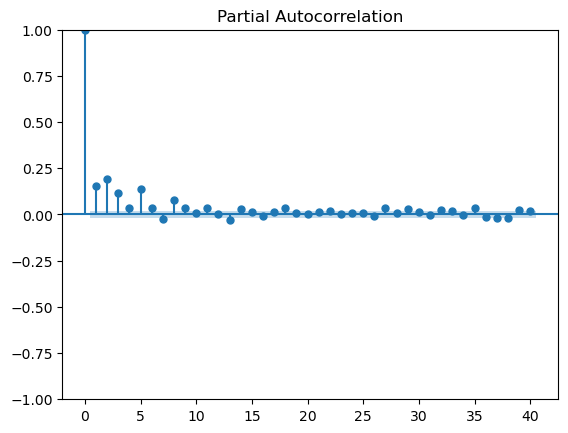

In [8]:
returns = msft_data['Percent_Change_Return']
plot_pacf(returns**2)
plt.show()

To keep my model simple, I am only going to be using up till lag 3

In [9]:
model = arch_model(returns, p=3, q=3)

In [10]:
model_fit = model.fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 168352.84902318037
Iteration:      2,   Func. Count:     22,   Neg. LLF: 13416734.57793083
Iteration:      3,   Func. Count:     33,   Neg. LLF: 21049.358302302775
Iteration:      4,   Func. Count:     45,   Neg. LLF: 20814.653339879478
Iteration:      5,   Func. Count:     57,   Neg. LLF: 40732.55283577893
Iteration:      6,   Func. Count:     68,   Neg. LLF: 19476.501218193698
Iteration:      7,   Func. Count:     78,   Neg. LLF: 19614.94106453064
Iteration:      8,   Func. Count:     88,   Neg. LLF: 19386.97311122712
Iteration:      9,   Func. Count:     98,   Neg. LLF: 19346.602852916745
Iteration:     10,   Func. Count:    108,   Neg. LLF: 19349.182970510847
Iteration:     11,   Func. Count:    118,   Neg. LLF: 19336.152550172603
Iteration:     12,   Func. Count:    127,   Neg. LLF: 19335.545587026063
Iteration:     13,   Func. Count:    136,   Neg. LLF: 19335.31368761576
Iteration:     14,   Func. Count:    145,   Neg. LLF: 19

In [11]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Constant Mean - GARCH Model Results                       
=================================================================================
Dep. Variable:     Percent_Change_Return   R-squared:                       0.000
Mean Model:                Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         GARCH   Log-Likelihood:               -19335.1
Distribution:                     Normal   AIC:                           38686.2
Method:               Maximum Likelihood   BIC:                           38743.4
                                           No. Observations:                 9463
Date:                   Sun, Oct 01 2023   Df Residuals:                     9462
Time:                           20:03:20   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1161  1.736e-02      6.690  2.238e-11 [8.211e-02,  0.150]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0749  3.034e-02      2.468  1.359e-02    [1.541e-02,  0.134]
alpha[1]       0.1047  2.457e-02      4.262  2.025e-05    [5.657e-02,  0.153]
alpha[2]   1.3899e-07  5.962e-02  2.331e-06      1.000      [ -0.117,  0.117]
alpha[3]   1.4259e-08  4.217e-02  3.381e-07      1.000 [-8.266e-02,8.266e-02]
beta[1]        0.5665      0.566      1.000      0.317      [ -0.544,  1.677]
beta[2]        0.0140      0.553  2.527e-02      0.980      [ -1.069,  1.097]
beta[3]        0.3006      0.121      2.489  1.282e-02    [6.389e-02,  0.537]
=============================================================================

Covariance estimator: robust
"""

From our GARCH Model, we can see that alpha[2], alpha[3], beta[1] & beta[2] are statistically insignificant to our model.
Therefore, I believe we can remove those terms & coefficients.

                       Constant Mean - GARCH Model Results                       
Dep. Variable:     Percent_Change_Return   R-squared:                       0.000
Mean Model:                Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         GARCH   Log-Likelihood:               -19335.1
Distribution:                     Normal   AIC:                           38682.2
Method:               Maximum Likelihood   BIC:                           38725.1
                                           No. Observations:                 9463
Date:                   Sun, Oct 01 2023   Df Residuals:                     9462
Time:                           20:12:58   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1161  1.742e-02     

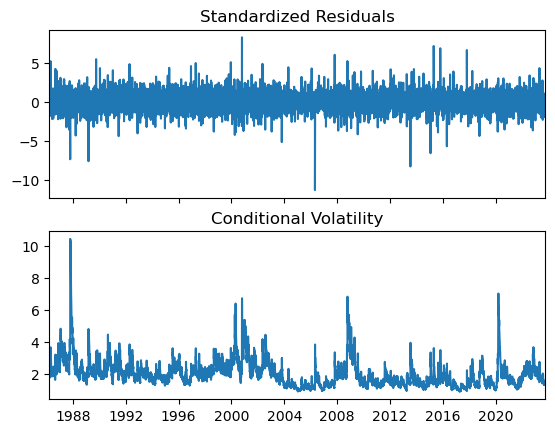

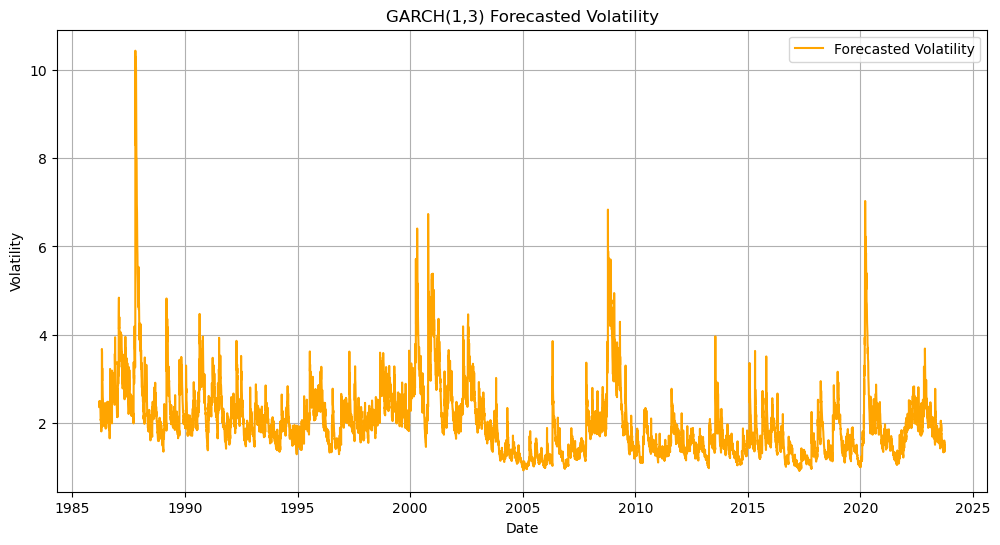

In [15]:
# Specify the GARCH(1,3) model with custom parameters
model = arch_model(returns, vol='Garch', p=1, q=3)
# Fit the model
results = model.fit(disp='off')
# Set the parameters
omega_value = 0.0749 
alpha1_value = 0.1047  
beta3_value = 0.3006    

results.params['omega'] = omega_value
results.params['alpha[1]'] = alpha1_value
results.params['beta[3]'] = beta3_value

# Forecast volatility using the updated model
forecast_volatility = results.conditional_volatility

# Print the model summary
print(results.summary())

results.plot()

# Plot the forecasted volatility
plt.figure(figsize=(12, 6))
plt.plot(msft_data.index, forecast_volatility, label='Forecasted Volatility', color='orange')
plt.title('GARCH(1,3) Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


To make my model even more accurate, I'm going to perform a rolling window algorithm. This means that the model predicts the next term's result & when the actual result comes out, it will take that actual result into account for the next prediction.

In [37]:
rolling_predictions = []
test_size = 365*5

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=3)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [38]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365*5:])

I will now plot my graph for comparison

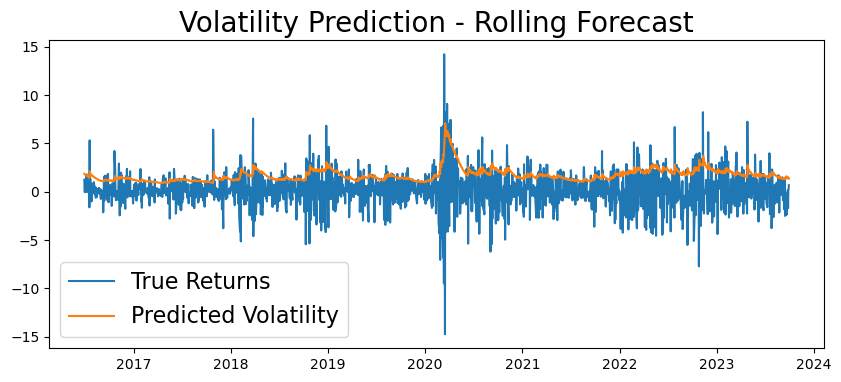

In [39]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-365*5:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

Application:

In [40]:
train = returns
model = arch_model(train, p=2, q=2)
model_fit = model.fit(disp='off')

In [41]:
pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

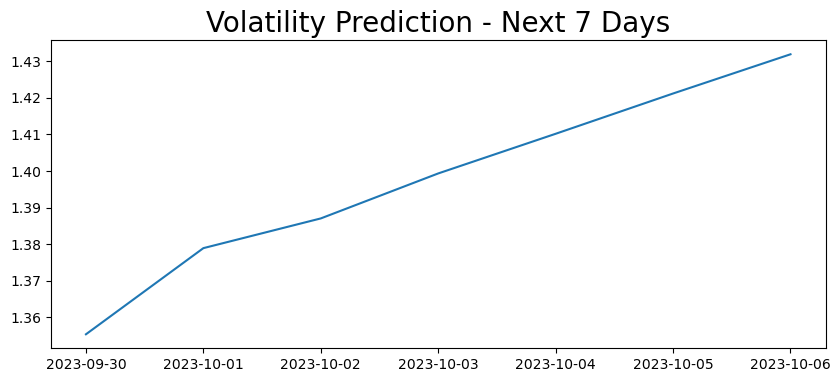

In [43]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)

Here is another rolling window feature where the rolling window size is specified as rolling_window, which can be adjusted as needed. It allows you to control the size of the rolling window, which is particularly useful if you want to experiment with different window sizes to see how they affect the predictions. Furthermore, the training data is selected using a rolling window approach, where a fixed window of data is used for training, and the window moves forward in time for each iteration. This allows you to simulate how the model would perform in a real-time forecasting scenario.

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
   

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
   

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
   

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
   

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
   

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
   

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
   

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
   

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
   

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Ite

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6009.927680764805
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 481677849.0541125
Iteration:      2,   Func. Count:     22,   Neg. LLF: 16491.674993565754
Iteration:      3,   Func. Count:     34,   Neg. LLF: 651148.6682735032
Iteration:      4,   Func. Count:     48,   Neg. LLF: 324054.91820679826
Iteration:      5,   Func. Count:     62,   Neg. LLF: -6009.927679741597
Optimization terminated successfully    (Exit mode 0)
            

C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jonat\anaconda3\Lib\site-packages\arch\univariate\base.py:310: DataSc

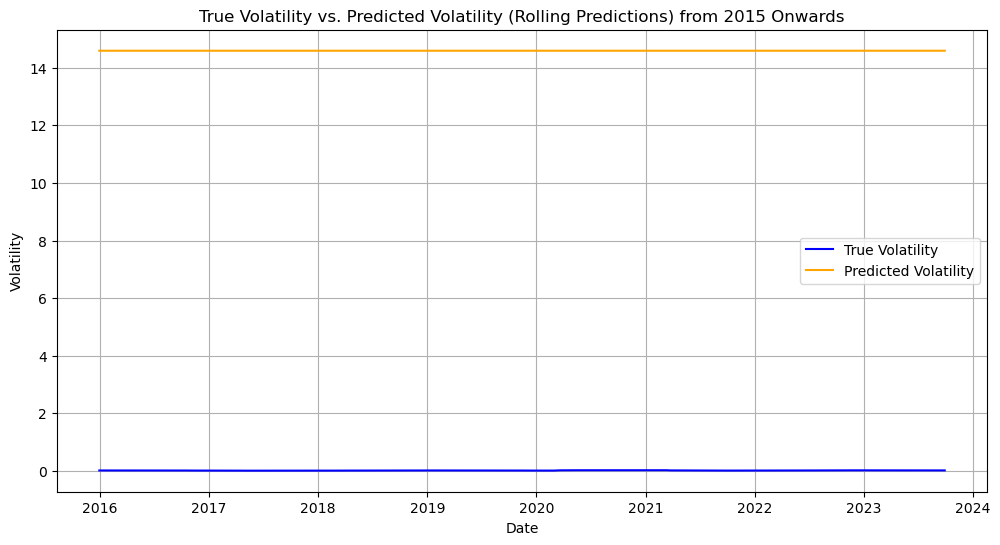

In [45]:
import numpy as np
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt
import pandas as pd

# Define the ticker symbol for Microsoft (MSFT)
ticker_symbol = "MSFT"

# Fetch historical data for Microsoft using yfinance
msft = yf.Ticker(ticker_symbol)
msft_data = msft.history(period="max")  # Fetch all historical data

# Calculate daily returns
msft_data['Daily_Return'] = msft_data['Close'].pct_change()

# Remove the first row (NaN) since there's no return for the first day
msft_data = msft_data.dropna()

# Filter data from the year 2015 onwards
msft_data_2015_onwards = msft_data['2015-01-01':]

# Specify the GARCH(1,3) model with custom parameters
model = arch_model(msft_data_2015_onwards['Daily_Return'], vol='Garch', p=1, q=3)

# Initialize empty lists to store true volatility, predicted volatility, and dates
true_volatility = []
predicted_volatility = []
dates = []

# Specify the rolling window size (e.g., 252 trading days per year)
rolling_window = 252

# Perform rolling predictions and update the model
for i in range(len(msft_data_2015_onwards) - rolling_window):
    train_data = msft_data_2015_onwards.iloc[i:i + rolling_window]
    
    train_returns = train_data['Daily_Return']  # Use the correct column name
    dates.append(train_data.index[-1])  # Store the date
    
    # Ensure that update_freq and disp have valid values
    update_freq = 1  # Replace with the appropriate value
    disp = "final"  # Replace with the appropriate value
    
    model_fit = model.fit(update_freq=update_freq, disp=disp)  # Use update_freq and disp
    
    # Set the parameters (omega, alpha[1], beta[3]) to your desired values
    omega_value = 0.0001  # Replace with your desired omega value
    alpha1_value = 0.1    # Replace with your desired alpha[1] value
    beta3_value = 0.8     # Replace with your desired beta[3] value

    # Update model parameters
    model_fit.params['omega'] = omega_value
    model_fit.params['alpha[1]'] = alpha1_value
    model_fit.params['beta[3]'] = beta3_value

    # Forecast volatility for the next day
    forecast = model_fit.forecast(start=train_returns.shape[0], horizon=1)
    predicted_volatility.append(np.sqrt(forecast.variance.values[-1, :][0]))
    
    # Calculate the true volatility (daily standard deviation)
    true_volatility.append(train_returns.std())

# Create DataFrames for true and predicted volatility
true_volatility = pd.Series(true_volatility, index=dates)
predicted_volatility = pd.Series(predicted_volatility, index=dates)

# Plot true volatility vs. predicted volatility
plt.figure(figsize=(12, 6))
plt.plot(true_volatility.index, true_volatility, label='True Volatility', color='blue')
plt.plot(predicted_volatility.index, predicted_volatility, label='Predicted Volatility', color='orange')
plt.title('True Volatility vs. Predicted Volatility (Rolling Predictions) from 2015 Onwards')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()
